In [1]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
nlp = spacy.load('en_core_web_sm')

with open('brennu-njals_saga_en.txt', 'r', encoding='utf-8') as file:
    book_text = file.read()

doc = nlp(book_text)

In [3]:
characters = []

for entity in doc.ents:
    if entity.label_ == 'PERSON':  # Consider only the entities labeled as persons
        characters.append(entity.text)

In [4]:
G2 = nx.Graph()

counter = Counter(characters)

for character in characters:
    G2.add_node(character)


In [30]:
for sentence in doc.sents:
    sentence_characters = []

    for entity in sentence.ents:
        if entity.label_ == 'PERSON':
            sentence_characters.append(entity.text)

    for i, character1 in enumerate(sentence_characters):
        for character2 in sentence_characters[i + 1:]:
            if G2.has_edge(character1, character2):
                G2[character1][character2]['weight'] += 1
            else:
                G2.add_edge(character1, character2, weight=1)

# Get a list of nodes without edges
isolated_nodes = [node for node, degree in dict(G2.degree()).items() if degree == 0]

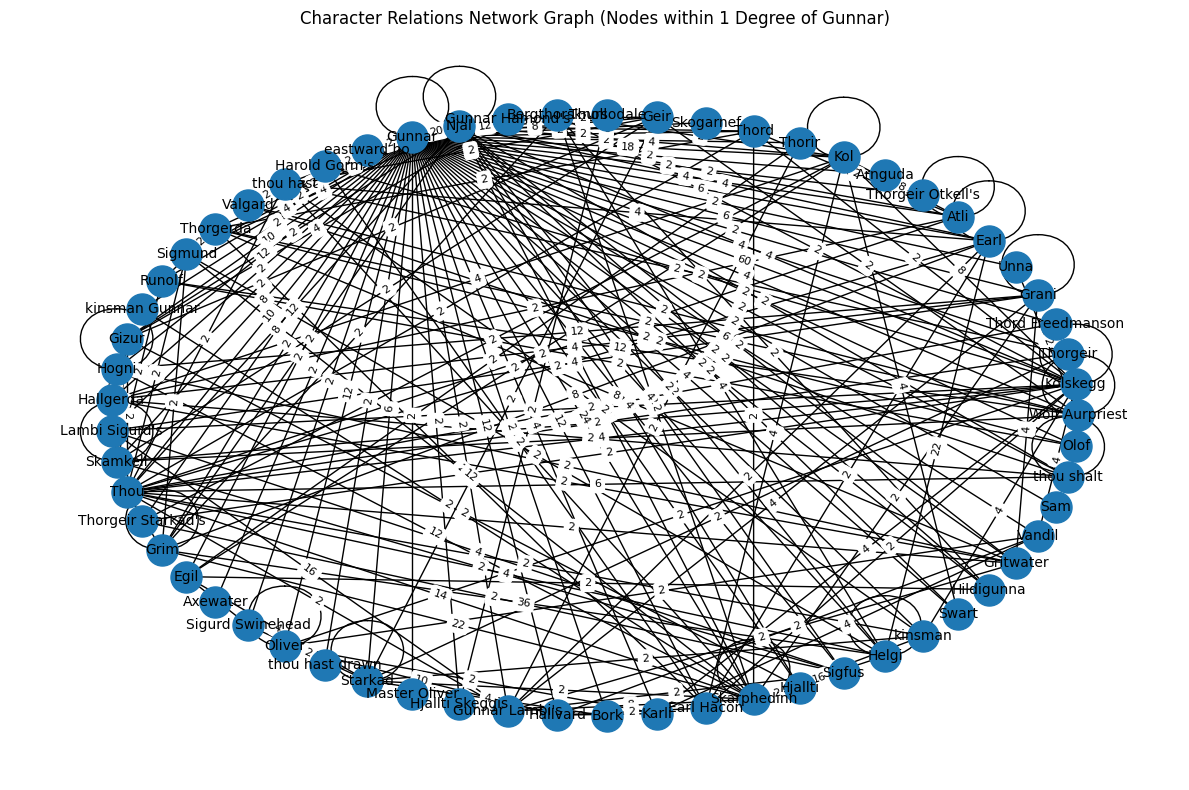

In [45]:
chosen_node = "Gunnar"  # Specify the chosen node

subgraph_nodes = set(nx.single_source_shortest_path_length(G2, chosen_node, cutoff=1))
subgraph = G2.subgraph(subgraph_nodes)

pos = nx.circular_layout(subgraph)  # Adjust layout algorithm as needed

plt.figure(figsize=(12, 8))
nx.draw_networkx(subgraph, pos, with_labels=True, node_size=500, font_size=10)
edge_labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=8)
plt.title(f'Character Relations Network Graph (Nodes within 1 Degree of {chosen_node})')
plt.axis('off')
plt.tight_layout()
plt.show()

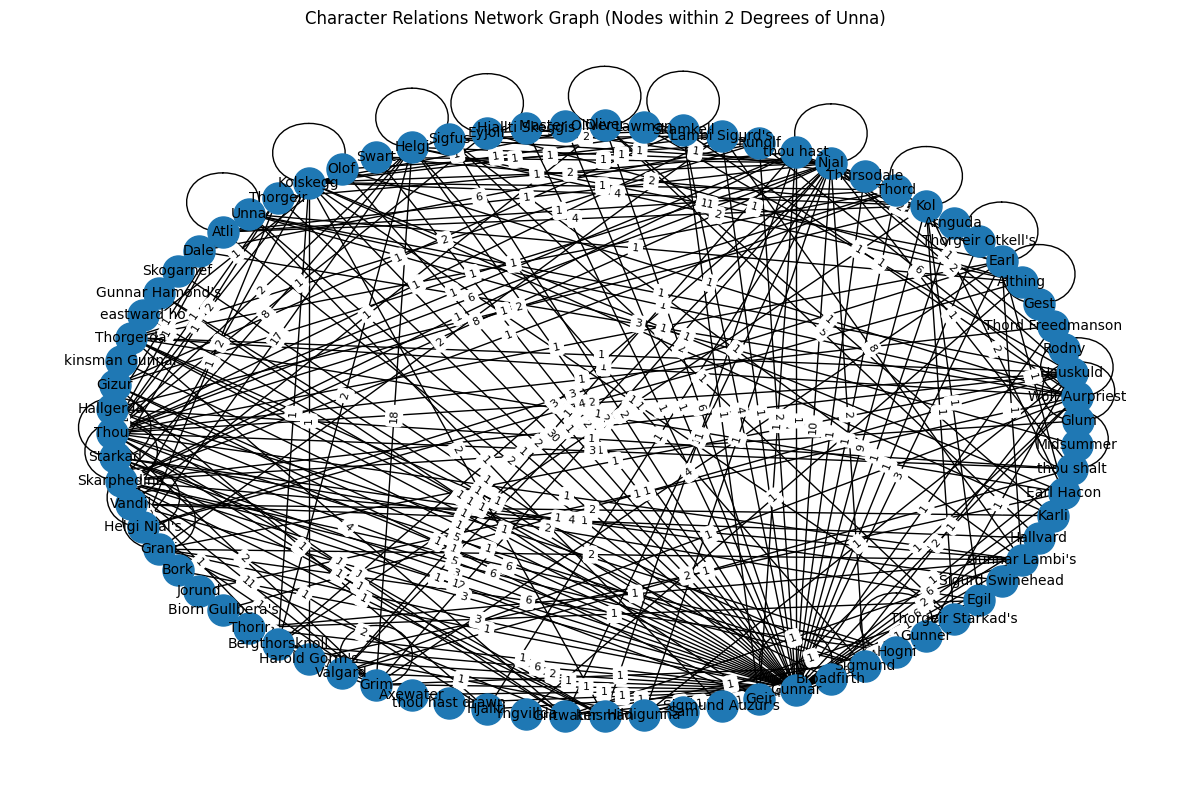

In [28]:
subgraph_nodes = set(nx.single_source_shortest_path_length(G2, chosen_node, cutoff=2))
subgraph = G2.subgraph(subgraph_nodes)

pos = nx.circular_layout(subgraph)  # Adjust layout algorithm as needed

plt.figure(figsize=(12, 8))
nx.draw_networkx(subgraph, pos, with_labels=True, node_size=500, font_size=10)
edge_labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=8)
plt.title(f'Character Relations Network Graph (Nodes within 2 Degrees of {chosen_node})')
plt.axis('off')
plt.tight_layout()
plt.show()

In [31]:
"Mord" in characters

False